## Traitement de données des observations:

Commençons par importer numpy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

A l'aide du logiciel Iris, nous avons pu utiliser les images enregistrées par le télescope T5 pour en déduire le flux de lumière de notre étoile AH Vir (Vmax=8.890 mag) ainsi que celle de notre étoile de comparaison HD 106815 (V=9.38 mag). 
Bien que le logiciel utilise une unité arbitraire (ADU), nous allons simplement utiliser le rapport entre les deux flux ainsi que la définition de magnitude apparente pour déterminer la magnitude de AH Vir à une phase donnée.
    
    
$$\begin{equation}
m_{HD 106815} - m_{AH Vir}=-2.5 \cdot \log\left(\frac{f_{HD 106815}}{f_{AH Vir}}\right)
\end{equation}$$

Commençons par créer une routine qui permet de déterminer la magnitude apparente de notre étoile. Ayant fait 5 observations par phases, nous allons également en profiter pour calculer la magnitude moyenne de chaque phase.


In [15]:
#--------------------------------------- Correction des phases
def Phasefix(mid,date,period=0.4075210000): #prend une date de mid et une date proche de ce mid
    interval=date-mid                       #fait la différence de la date du mid et la date à corriger
    out=interval/period                     #calcule la phase corrigée correspondant à la date
    return out

def midcalculator(date,phase,period=0.4075210000):#prend une phase et la date correspondante
    mid=date-(phase*period)                       #calcule le premier mid le plus proche
    return mid




phases = [0.0, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.6875, 0.75, 0.875, 0.9375]

datelist=[[2458961.79995,2458961.80049,2458961.80090,2458961.80132,2458961.80172],
          [2458957.80343,2458957.80396,2458957.80437,2458957.80479,2458957.80520],
          [2458977.79815,2458977.79868,2458977.79951,2458977.79993,2458977.79910],
          [2458955.81736,2458955.81795,2458955.81836,2458955.81877,2458955.81919],
          [2458942.80451,2458942.80509,2458942.80550,2458942.80593,2458942.80634],
          [2458951.79287,2458951.79345,2458951.79385,2458951.79428,2458951.79470],
          [2458967.71182,2458967.71237,2458967.71279,2458967.71321,2458967.71362],
          [2458958.82078,2458958.82131,2458958.82171,2458958.82213,2458958.82255],
          [2458954.77248,2458954.77307,2458954.77348,2458954.77389,2458954.77431],
          [2458943.82081,2458943.82135,2458943.82177,2458943.82218,2458943.82259],
          [2458966.66503,2458966.66559,2458966.66601,2458966.66642,2458966.66697]]


olddates=[2458961.804470009,2458957.8056701953,2458977.7996692644,2458955.81900532,2458942.803803378,
          2458951.7947354433,2458967.713524511,2458958.8244726956,2458954.774732757,2458943.822605878,2458966.669251948]






phasefixes=[]
for i in range(len(phases)):
    phasefixes.append([])
    for j in range(len(datelist[i])):
        mid=midcalculator(olddates[i],phases[i],period=0.4075210000)
        fix=Phasefix(mid,datelist[i][j],period=0.4075210000)
        phasefixes[i].append(fix)


def mag_finder(Fvir,Fcomp,phases, phasefixes):
#--------------------------------------- Constante et listes vides
    mcomp=9.38     #Magnitude apparente de HD 106815
    Mvir=[]        #Liste allant stocker les magnitudes apparentes de AH Vir (5 par phase)
    Means=[]       #Liste allant stocker les moyennes de chaque phase
    Sigmas=[[],[]] #Liste allant stocker les écarts-type des phases et des magnitudes
    
#--------------------------------------- Routine principale
    for i in range (len(phases)):         #i va compter le nombre de phases
        Mvir.append([])                   #On crée une liste dans Magnitude Vir pour chaque phase
        print('Phase %s:'%(phases[i]))    #Cette étape ne sert que pour présenter les résultats pour une phase donnée
        for j in range(len(Fvir[i])):     #Cette boucle va nous calculer la magnitude pour chaque observation
            Mvir[i].append(mcomp+2.5*np.log10(Fcomp[i][j]/Fvir[i][j]))
            print('\n', Mvir[i][j])       #Nous retournons la j^ème observation de la phase i
        Means.append(np.mean(Mvir[i]))    #Nous faisons la moyenne la phase i
        print("Magnitude moyenne:",Means[i], "\n") #Nous retournons enfin chaque moyenne
        
#--------------------------------------- Calcul d'erreurs 
        xmu, xsquare, ymu, ysquare = 0, 0, 0, 0    #Nous servira d'itération pour définir l'écart-type
        for j in range (len(Fvir[i])):             #Calcul des mu
            ymu=ymu+(Fcomp[i][j]/Fvir[i][j])       #Nous sommons tous les rapports
            xmu=xmu+phasefixes[i][j]
        ymu, xmu = ymu/(j+1), xmu/(j+1)                   #Et divisons par les j+1 éléments 
        for j in range (len(Fvir[i])):                    #Nous calculons maintenant la somme des carrées
            ysquare, xsquare = ysquare+((Fcomp[i][j]/Fvir[i][j])-ymu)**2, xsquare+(phasefixes[i][j]-xmu)**2
        ysquare, xsquare = ysquare/(j+1), xsquare/(j+1)   #Divisons par j+1 afin d'obtenir la variance
        ysigma, xsigma =(ysquare)**(1/2), (xsquare)**(1/2)                           #-> Ecart-type pour la phase i
        Sigmas[0].append(ysigma)                          #On rajoute le sigma dans la liste Sigmas

        print("Ecart-type du rapport de flux:", Sigmas[0][i])
        Sigmas[1].append(xsigma)
    
        Sigmas[0][i]=(2.5*(1/(np.log(10)*ymu)*(Sigmas[0][i])))   #On convertie en magnitude en propageant 
        print("Erreur sur la magnitude:", Sigmas[0][i])
        print("Erreur sur la phase:", Sigmas[1][i])                                                         #l'erreur
    
    return(Means, Sigmas)

In [16]:
Fvir = [[108270.0, 107773.0, 112423.0, 111360.0, 113026.0],
        [98716.0, 98713.0, 97501.0, 97782.0, 98348.0],
        [74482.0, 75613.0, 74757.0, 75078.0, 73293.0],
        [71043.0, 70982.0, 72328.0, 71254.0, 71979.0],
        [94836.0, 93492.0, 95705.0, 94759.0, 95687.0],
        [104809.0, 104274.0, 102768.0, 102573.0, 95269.0],
        [109557.0, 109874.0, 110211.0, 111547.0, 110392.0],
        [92840.0, 98088.0, 96153.0, 89407.0, 96309.0],
        [72768.0, 72167.0, 72485.0, 71975.0, 72245.0],
        [81503.0, 82357.0, 84309.0, 83274.0, 83617.0],
        [102233.0, 103113.0, 103302.0, 104388.0, 103669.0]]

Fcomp = [[77425.0, 76746.0, 76913.0, 76106.0, 76552.0],
         [77668.0, 77791.0, 77187.0, 77976.0, 76952.0],
         [74741.0, 74138.0, 75209.0, 75677.0, 75528.0],
         [79183.0, 80957.0, 80231.0, 81078.0, 79718.0],
         [80870.0, 83256.0, 82729.0, 82534.0, 81540.0],
         [77798.0, 77951.0, 75128.0, 77109.0, 73263.0],
         [76398.0, 76603.0, 76501.0, 76267.0, 76652.0],
         [77267.0, 77459.0, 76059.0, 77475.0, 77463.0],
         [74709.0, 76043.0, 75814.0, 76404.0, 75922.0],
         [75394.0, 75083.0, 74800.0, 75063.0, 75563.0],
         [78298.0, 79093.0, 78707.0, 78166.0, 79153.0]]



M_AHVir = mag_finder(Fvir,Fcomp,phases, datelist)
print(M_AHVir)

Phase 0.0:

 9.015932693124137

 9.011364442871788

 8.96786145289851

 8.96672418626589

 8.956945458551981
Magnitude moyenne: 8.98376564674246 

Ecart-type du rapport de flux: 0.015879691662590966
Erreur sur la magnitude: 0.024828308887971696
Erreur sur la phase: 0.0006191155295396816
Phase 0.1875:

 9.119636431575286

 9.121387508879241

 9.12633772927242

 9.134255092813216

 9.113635947930776
Magnitude moyenne: 9.123050542094187 

Ecart-type du rapport de flux: 0.005035645623397854
Erreur sur la magnitude: 0.006927083719270298
Erreur sur la phase: 0.000618869908387118
Phase 0.25:

 9.383768935880004

 9.358610991655642

 9.38654487351275

 9.38862803103255

 9.412613715496162
Magnitude moyenne: 9.386033309515422 

Ecart-type du rapport de flux: 0.015877027238797692
Erreur sur la magnitude: 0.017140600295068233
Erreur sur la phase: 0.0006216944405263769
Phase 0.3125:

 9.497776648215897

 9.522765435839986

 9.49258937262934

 9.520234444270017

 9.490876464160747
Magnitude moyenne

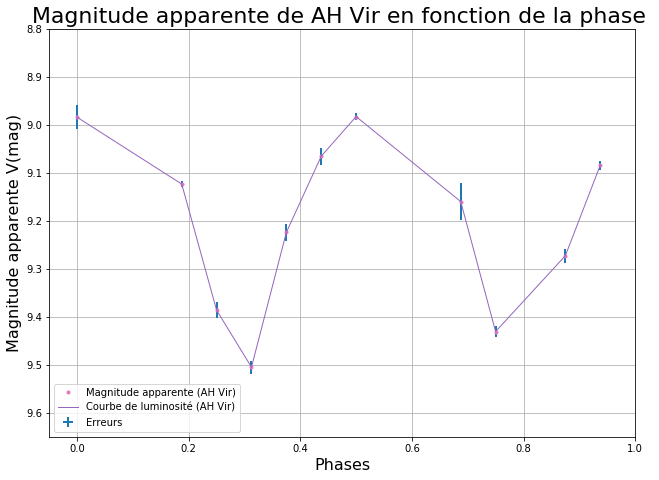

In [17]:
Mag, Err1, Err2, Phases = np.array(M_AHVir[0]), np.array(M_AHVir[1][0]), np.array(M_AHVir[1][1]), (np.array(phases))
#sigma=np.array([,])
#--------------------------------------------------------------------------------- Graphe
plt.figure(figsize=(10.5,7.5))
plt.title('Magnitude apparente de AH Vir en fonction de la phase ', size=22)
plt.xlabel('Phases', size=16)
plt.ylabel('Magnitude apparente V(mag)', size=16)
plt.plot(Phases,Mag,".", label='Magnitude apparente (AH Vir)',
            color='C6', lw=10)
plt.plot(Phases,Mag,"-", label='Courbe de luminosité (AH Vir)',
            color='C4', lw=1)
plt.errorbar(Phases,Mag ,xerr=Err2,yerr=Err1, label='Erreurs',
            color='C0', linestyle='' ,linewidth=2)
plt.legend(loc='lower left')
plt.xlim(-0.05,1.)
plt.ylim(9.65,8.8)
plt.grid()

In [ ]:
data=pd.DataFrame(Mag, index=phases, columns=['Mag Moyenne'])
data.head(11)